Exploring augmentations

In [20]:
# import packages
import os
import numpy as np
import torch

from torchvision import transforms as T
from torchvision.transforms import functional as F

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
# load image and mask pair
imPath = './valTest/images/'
maskPath = './valTest/masks/'
fname = 'img027.png'
image0 = Image.open(os.path.join(imPath,fname))
mask0 = Image.open(os.path.join(maskPath,fname))

In [89]:
# load image and mask pair
imPath = '../ManuallyLabelled_nocrop/images/'
maskPath = '../ManuallyLabelled_nocrop/masks/'
fname = 'PCB11salrh_108.png'
image0 = Image.open(os.path.join(imPath,fname))
mask0 = Image.open(os.path.join(maskPath,fname))

print(f'Original image size: {image0.size}')
print(f'Original mask size: {mask0.size}')

Original image size: (814, 646)
Original mask size: (814, 646)


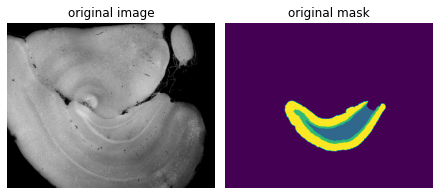

In [90]:
fig, axs = plt.subplots(1,2,constrained_layout=True)
axs[0].imshow(image0,cmap='gray',vmin=0,vmax=255)
axs[0].axis('off')
axs[0].set_title('original image')
axs[1].imshow(mask0,vmin=0,vmax=3)
axs[1].axis('off')
axs[1].set_title('original mask');

In [132]:
# augmentation parameters
crop = (512,512)
color_jitter_params = None
long_mask = False

p_hflip = 0.0 #0.25
p_vflip = 0.0 #0.25
p_noise = 0.5 #0.25
noise_sigma = 15
p_random_affine = 1.0 #0.5
random_affine_params = (-15, 15, 0.1, 0.1, 0.9, 1.1, -10, 10) #(-20, 20, 0.25, 0.25, 0.75, 1.25, -20, 20)

In [135]:
n_epochs = 4

if crop:
    imageList = np.zeros((crop[0],crop[1],n_epochs))
    maskList = np.zeros((crop[0],crop[1],n_epochs))
else:
    imageList = np.zeros((image0.size[0],image0.size[1],n_epochs))
    maskList = np.zeros((image0.size[0],image0.size[1],n_epochs))

allAT = []
for e in range(n_epochs):
    image = image0.copy()
    mask = mask0.copy()
    appliedTransforms = []
    
    if np.random.rand() < p_noise:
        noise = np.random.normal(0.0, noise_sigma, image.size).transpose()
        tmpim = np.array(image)
        tmpim = tmpim+noise
        image = Image.fromarray(tmpim)
        appliedTransforms.append('Noise')
    
    if np.random.rand() < p_hflip:
        image, mask = F.hflip(image), F.hflip(mask)
        appliedTransforms.append('HFlip')
        
    if np.random.rand() < p_vflip:
        image, mask = F.vflip(image), F.vflip(mask)
        appliedTransforms.append('VFlip')
        
    if color_jitter_params:
        color_tf = T.ColorJitter(*color_jitter_params)
        image = color_tf(image)
        appliedTransforms.append('ColorJitter')
    
    imageCopy = image.copy()
    maskCopy = mask.copy()
    
    dummy = Image.fromarray(np.zeros((image.size[0],image.size[1])).transpose())
    if np.random.rand() < p_random_affine:
        appliedTransforms.append('RandomAffine')
        affine_params = T.RandomAffine.get_params(random_affine_params[0:2],
                                       random_affine_params[2:4],
                                       random_affine_params[4:6],
                                       random_affine_params[6:8],
                                       image.size)
        dummy = F.affine(dummy, *affine_params,T.InterpolationMode.NEAREST,255)
        image, mask = F.affine(image, *affine_params,T.InterpolationMode.NEAREST,255), F.affine(mask, *affine_params,T.InterpolationMode.NEAREST,255)
        
    
    if crop:
        i, j, h, w = T.RandomCrop.get_params(image, crop)
        dummy = F.crop(dummy, i, j, h, w)
        image, mask = F.crop(image, i, j, h, w), F.crop(mask, i, j, h, w)
        appliedTransforms.append('Crop')
    
    dummy = np.any(np.array(dummy)==255)
    
    if dummy:
        image, mask = F.crop(imageCopy, i, j, h, w), F.crop(maskCopy, i, j, h, w)
        print('Dropping affine because out of bounds')
        
    
    allAT.append(appliedTransforms)
    
    imageList[:,:,e] = np.array(image)
    maskList[:,:,e] = np.array(mask)

Dropping affine because out of bounds
Dropping affine because out of bounds


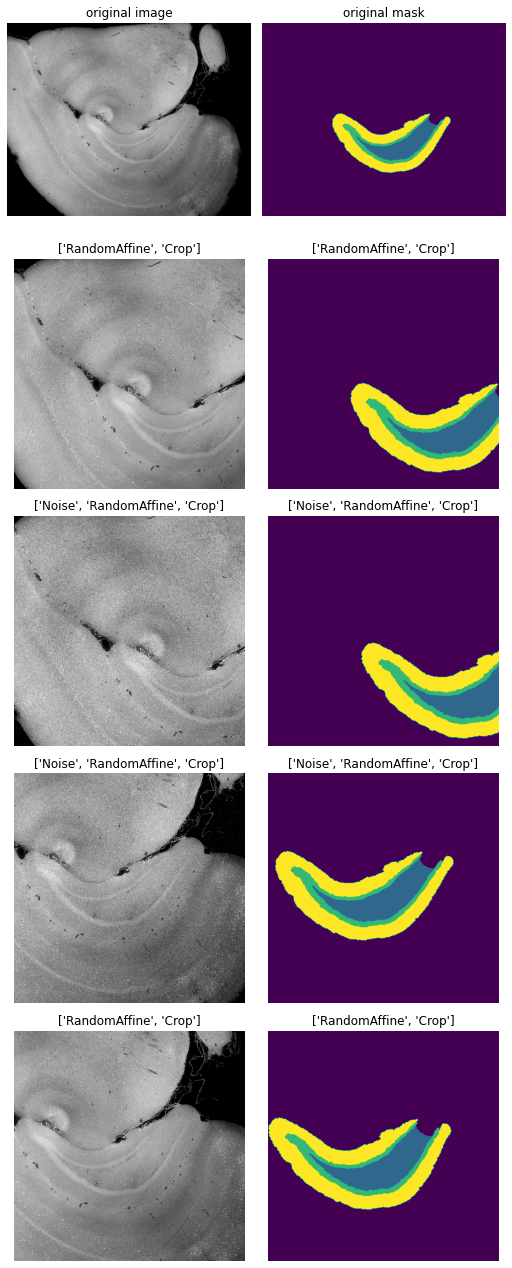

In [136]:
fig, axs = plt.subplots(n_epochs+1,2,constrained_layout=True)
fig.set_size_inches(7,3.5*(n_epochs+1))

axs[0,0].imshow(image0,cmap='gray',vmin=0,vmax=255)
axs[0,0].axis('off')
axs[0,0].set_title('original image')
axs[0,1].imshow(mask0,vmin=0,vmax=3)
axs[0,1].axis('off')
axs[0,1].set_title('original mask');

for e in range(n_epochs):
    axs[1+e,0].imshow(imageList[:,:,e],cmap='gray',vmin=0,vmax=255)
    axs[1+e,0].axis('off')
    axs[1+e,0].set_title(allAT[e])
    axs[1+e,1].imshow(maskList[:,:,e],vmin=0,vmax=3)
    axs[1+e,1].axis('off')
    axs[1+e,1].set_title(allAT[e]);